<a href="https://colab.research.google.com/github/BigSmoke321/MLDM-2023/blob/main/08-ensembles/Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembles: bagging & boosting

### Preliminary things (from the last seminar)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [3]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """

    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )

    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)

    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)

    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))

    plt.legend(loc='best')

#### Toy multiclass data

In [7]:
!gdown 1WDDKJX_pbjK2buNEKEWJqyUHPUGPpRzo

Downloading...
From: https://drive.google.com/uc?id=1WDDKJX_pbjK2buNEKEWJqyUHPUGPpRzo
To: /content/data.npz
100% 108k/108k [00:00<00:00, 78.4MB/s]


Firstly, we'll load the data:

In [8]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


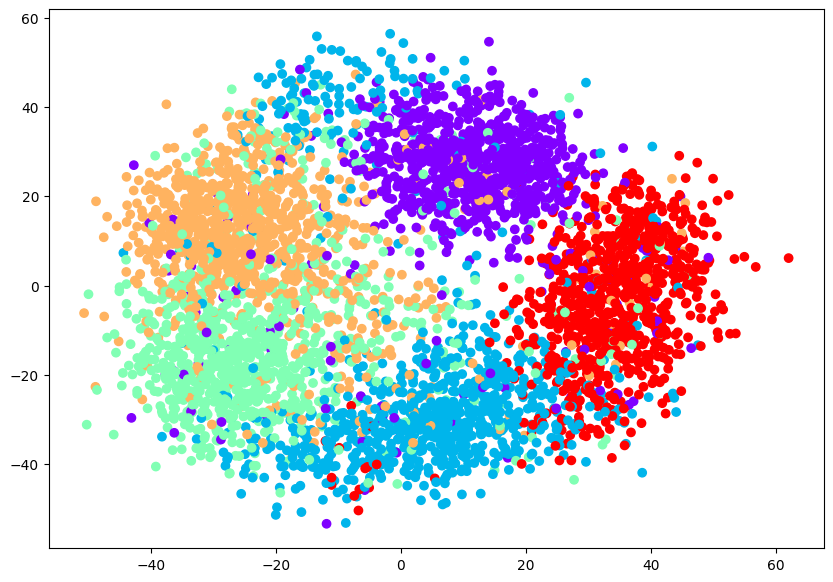

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(*X.T, c=y, cmap='rainbow');

And then split it to train and test:

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

Now that we've had a look at the data, let's fit a decision tree on it:

In [11]:
clf = DecisionTreeClassifier(min_samples_leaf=12)
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=12)

and plot the result:

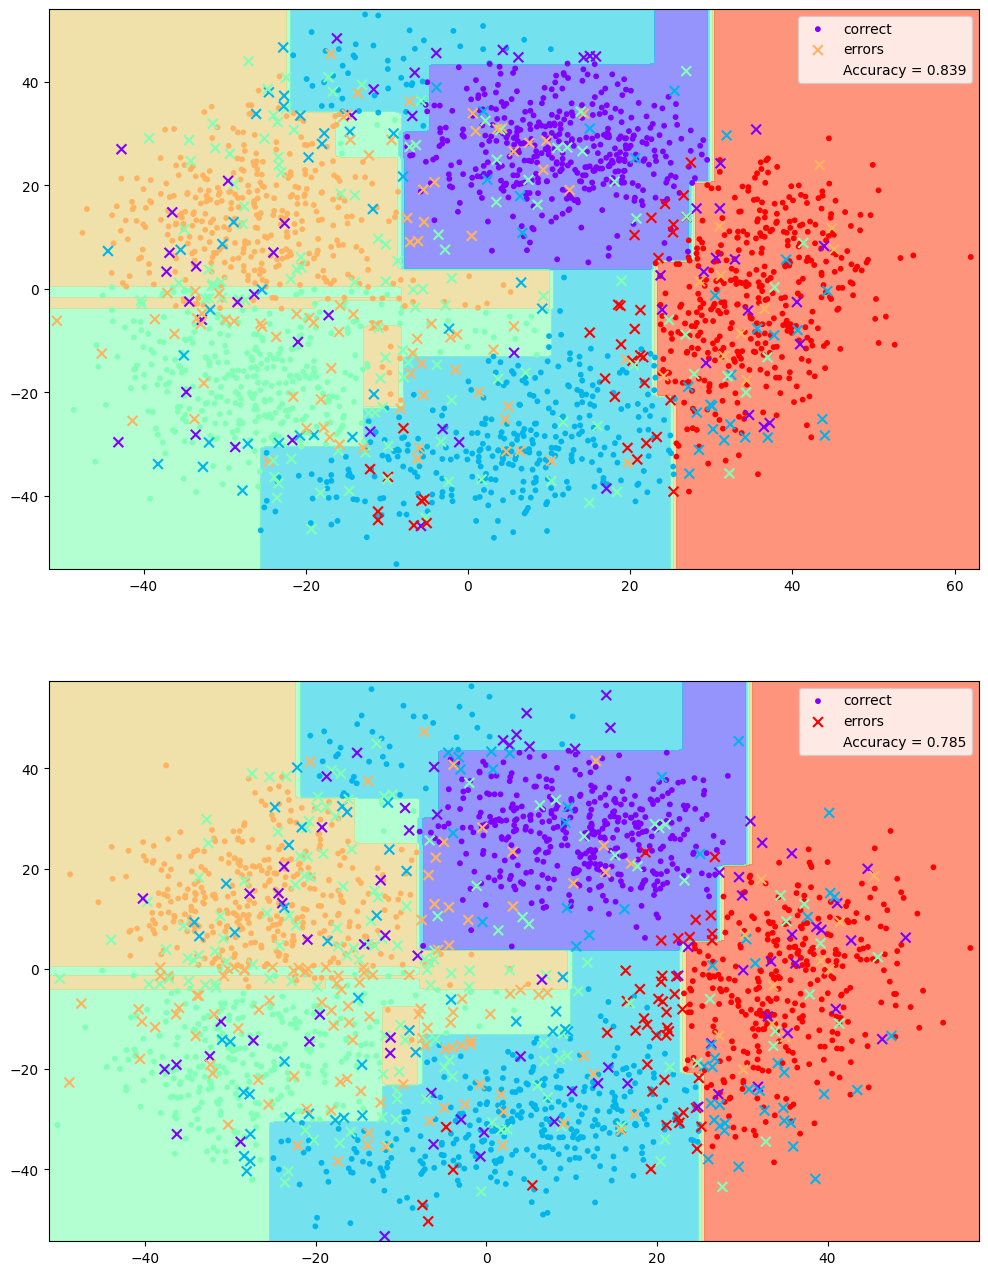

In [12]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');

```

```

```

```

```

```

```

```

## Ensembles

### Bagging

Let's build our own decision tree bagging and see how well it works. Implement the **`BagOfTrees`** class below **(2 points)**:

In [19]:
class BagOfTrees:
  def __init__(self, n_estimators=10, **kwargs):
    self.trees = []
    for i in range(n_estimators):
        self.trees.append(DecisionTreeClassifier(**kwargs))

  def fit(self, X, y):
    # Fit each of the trees on a random subset of X and y.
    # hint: you can select random subsample of data like this:
    # >>> ix = np.random.randint(0, len(X), len(X))
    # >>> X_sample, y_sample = X[ix], y[ix]

    for tree in self.trees:
      ix = np.random.randint(0, len(X), len(X))
      X_sample, y_sample = X[ix], y[ix]
      tree.fit(X_sample, y_sample)

  def predict(self, X):
    trees = self.trees
    outs_prob = []
    outs = []

    for tree in trees:
      outs.append(tree.predict(X))
      #outs_prob.append(tree.predict_proba(X))
    # Compute predictions of each tree and aggregate them into
    # the ensemble prediction
    # Note: you can use tree.predict(X) to get the predicted classes
    # or tree.predict_proba(X) to get individual probabilities
    # for all classes

    return mode(outs)[0]

# once you think you're done, see if your code passes the asserts below

In [20]:
model = BagOfTrees(n_estimators=3, min_samples_leaf=3)
model.fit(X_train, y_train)

pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "Some trees are identical. Did you forget to train each tree on a random part of the data?"

NameError: ignored

If the cell above executes without errors, run the code below to compare overall accuracy with individual tree accuracies:

In [ ]:
for i, tree in enumerate(model.trees[:5]):
    print("tree {} individual accuracy = {:.5f}".format(
        i, accuracy_score(y_test, tree.predict(X_test))
      ))

print("Ensemble accuracy:",
      accuracy_score(model.predict(X_test), y_test)) # should be >= 0.78

And have a look at the decision surface:

In [ ]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(model, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(model, X_test, y_test, cmap='rainbow');

Now let's check how train and test accuracy depends on the number of estimators **(1 point)**.

Hint: instead of fitting a new BagOfTrees for each number of estimators we can just fit the maximum number and then iteratively predict and remove the fitted trees one by one.

In [ ]:
model = BagOfTrees(n_estimators=100, min_samples_split=30, splitter='random', random_state=42)
model.fit(X_train, y_train)

n_trees = []
test_score = []
train_score = []

<YOUR CODE HERE> # fill the lists above to make the plot


plt.plot(n_trees, train_score, label='train')
plt.plot(n_trees, test_score, label='test')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy');

```
```
```
```
```
```

### Pre-implemented ensembles: Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with
# 100 estimators and at least 5 samples per leaf

model = <YOUR CODE>

<YOUR CODE>

plt.figure(figsize=(12, 8))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')

```
```
```
```

### Pre-implemented ensembles: Gradient Boosting

One of the most commonly used libraries for gradient boosing is the [XGBoost library](https://xgboost.ai/). Consider reading [this document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) for an introduction to the algorithm.

Here's the [help page](https://xgboost.readthedocs.io/en/latest/parameter.html) listing available parameters.

Let's start by importing the classifier class and the function that plots individual trees as graphs:

In [ ]:
from xgboost import XGBClassifier, plot_tree

We can now investigate how decision surface depends on the number of trees:

In [ ]:
for n_estimators in range(1,10):
    model = <YOUR CODE> # create an XGBClassifier with trees of depth 1,
                        # learning rate 0.5 and n_estimators estimators

    <YOUR CODE> # fit this model to the train data

    print("n_estimators = ", n_estimators)
    plt.figure(figsize=(8, 5))
    plot_decision_surface(model, X_test, y_test, cmap='rainbow')
    plt.show()

And here's how one may use the `plot_tree` function:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_tree(model, num_trees=44, ax=ax, dpi='400');
#                   ^^^ This parameter selects the
#                       tree that you want to plot.
#                       Since there's 9 estimators
#                       in the last model and 5
#                       classes in our data, the total
#                       amount of individual trees
#                       is 45 (from 0 to 44).

<font color='red'>**Warning:**</font> current xgboost implementation is not very safe to typos, i.e. it can silently swallow whatever argument you provide, even if it has no effect, e.g.:

In [ ]:
model = XGBClassifier(abrakadabra="I won't change anything")
model

so be sure to check your spelling.

Now let's try to improve the score by adjusting the parameters. Here are some of the parameters you may want to try:
  - `max_depth` – maximum tree depth,
  - `n_estimators` – number of trees (per class),
  - `learning_rate` – shrinkage,
  - `reg_lambda` – L2 regularization term on weights,
  - `subsample` – row random subsampling rate (per tree),
  - `colsample_bynode` – column subsampling rate (per node)
  - `gamma` – minimum loss reduction required to make a further partition on a leaf node of the tree

See [this page](https://xgboost.readthedocs.io/en/latest/parameter.html) for more information.

  > *Hint: since XGBClassifier has the same interface as sklearn models, you can use GridSearchCV on it if you want.*

In [ ]:
model = <YOUR CODE HERE>

model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')
plt.show();

### Hyperparameter optimization

In [ ]:
!pip install optuna

[Optuna](https://optuna.org/) is framework agnostic. You can use it with any machine learning or deep learning framework like sklearn, catboost, PyTorch, etc.

You can optimize XGBoost hyperparameters in three steps:

1. Wrap model training with an `objective` function and return accuracy
2. Suggest hyperparameters using a `trial` object
3. Create a `study` object and execute the optimization

In [ ]:
def objective(trial):
    # define the grid
    param = {
        "verbosity": 0,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = XGBClassifier()
    bst.set_params(**param)
    bst.fit(X_train, y_train)
    preds = bst.predict(X_test)
    pred_labels = np.rint(preds)
    # objective should return the metrics that you want to optimize
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
# you may increase the nubmer of trials in case you have enough time
study.optimize(objective, n_trials=10, timeout=600)

In [ ]:
print("  Best value: {}".format(study.best_trial.value))


In [ ]:
model = XGBClassifier()
model.set_params(**study.best_params)

model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')
plt.show();

```
```
```
```

## Feature importance

For this example we are going to use California Housing Dataset.

The **target** variable is the median house value for California districts.


The features are:
 *   **MedInc** median income in block
 *   **HouseAge** median house age in block
 *   **AveRooms** average number of rooms
 *   **AveBedrms** average number of bedrooms
 *   **Population** block population
 *   **AveOccup** average house occupancy
 *   **Latitude** house block latitude
 *   **Longitude** house block longitude

 More information [here](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [ ]:
dataset = fetch_california_housing()

`dataset` holds the data in numpy arrays, but we can convert it to a pandas dataframe:

In [ ]:
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

data.head(10)

Now, let's separate the features from the target and split the data to train and test parts:

In [ ]:
data_X = data.drop('target', axis=1)
data_y = data['target']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.5)
print(X_train.shape, X_test.shape)

and grid search for best random forest parameters on it:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(n_estimators=30)

gscv = GridSearchCV(model,
                    param_grid=<YOUR CODE HERE>,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    cv=3,
                    verbose=3)


gscv.fit(X_train, y_train)
model = gscv.best_estimator_
print(model)

print("Train loss:", mean_squared_error(y_train, model.predict(X_train)))
print("Test loss:" , mean_squared_error(y_test , model.predict(X_test )))

Once fit, the model has the information about importances of individual features, calculated from gain in individual splits.

In [ ]:
# get the estimates of feature importances
importances = model.feature_importances_
# calculate the std:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# This part will be used to make nice x-axis labels
# (we'll tell matplotlib to convert numeric feature
# index to a text label):
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(importances)):
        return dataset.feature_names[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots(figsize=(13,7))
ax.set_title("Feature importances")
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xlim([-1, len(importances)])
plt.show();

You may also use trees to evaluate the impurity based importance of the pixels in an image classification task on the faces dataset. The hotter the pixel, the more important it is.

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge.

There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).

The “target” for this database is an integer from 0 to 39 indicating the identity of the person pictured; however, with only 10 examples per class, this is relatively small dataset.

In [ ]:
data = fetch_olivetti_faces()
X, y = data.data, data.target
mask = y < 5 # let's pick only 5 classes
X = X[mask]
y = y[mask]
model = RandomForestClassifier(n_estimators=750, random_state=42)

model.fit(X, y)

In [ ]:
img_shape = data.images[0].shape
importances = model.feature_importances_
imp_reshaped = importances.reshape(img_shape)
plt.figure(figsize = (6,6))
plt.matshow(imp_reshaped, fignum=1)
plt.title("Pixel importances using impurity values")
plt.axis('off')
plt.show()